In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [2]:
data_path = "dataset/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()
  

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:11<00:00, 11.28it/s]


In [3]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [4]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts    

In [5]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk

# Download the necessary NLTK data
nltk.download('punkt')

# Lowercasing
prompts_lowercased = [prompt.lower() for prompt in prompts]

# Removing Punctuation and Special Characters
prompts_cleaned = [re.sub(r'[^\w\s]', '', prompt) for prompt in prompts_lowercased]

# Tokenization
prompts_tokenized = [word_tokenize(prompt) for prompt in prompts_cleaned]

# Stemming
stemmer = PorterStemmer()
prompts_stemmed = [[stemmer.stem(word) for word in tokens] for tokens in prompts_tokenized]



# Print the results
for i, prompt in enumerate(prompts):
    print(f"Original: {prompt}")
    print(f"Lowercased: {prompts_lowercased[i]}")
    print(f"Cleaned: {prompts_cleaned[i]}")
    print(f"Tokenized: {prompts_tokenized[i]}")
    print(f"Stemmed: {prompts_stemmed[i]}")
,

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\can_z\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Original: Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. 

Lowercased: load a csv file into a pandas in python. the file is named 'cs412_hw1_dataset.csv' and contains columns like 'species', 'island', 'sex', 'diet', 'year', 'life stage', 'body mass (g)', 'bill length (mm)', 'bill depth (mm)', 'flipper length (mm)', and 'health metrics'. 

Cleaned: load a csv file into a pandas in python the file is named cs412_hw1_datasetcsv and contains columns like species island sex diet year life stage body mass g bill length mm bill depth mm flipper length mm and health metrics 

Tokenized: ['load', 'a', 'csv', 'file', 'into', 'a', 'pandas', 'in', 'python', 'the', 'file', 'is', 'named', 'cs412_hw1_datasetcsv', 'and', 'contains', 'columns', 'like', 'species', 'island', 'sex', 'diet

''

In [6]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [7]:
import nltk

# Download the necessary NLTK data
nltk.download('wordnet')


vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

# Text preprocessing
questions_lowercased = [question.lower() for question in questions]
questions_cleaned = [re.sub(r'[^\w\s]', '', question) for question in questions_lowercased]
questions_tokenized = [word_tokenize(question) for question in questions_cleaned]

stemmer = PorterStemmer()
questions_stemmed = [[stemmer.stem(word) for word in tokens] for tokens in questions_tokenized]

lemmatizer = WordNetLemmatizer()
questions_lemmatized = [[lemmatizer.lemmatize(word) for word in tokens] for tokens in questions_tokenized]

# Vectorization using TfidfVectorizer
vectorizer = TfidfVectorizer()
questions_tfidf = vectorizer.fit_transform(questions)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\can_z\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF

10        15        20        80        __  _________    __note   
0  0.000000  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000  \
1  0.000000  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   
2  0.042894  0.054406  0.000000  0.000000  0.000000   0.000000  0.000000   
3  0.000000  0.000000  0.137079  0.186662  0.000000   0.000000  0.000000   
4  0.046264  0.000000  0.000000  0.000000  0.079906   0.000000  0.079906   
5  0.000000  0.073144  0.073144  0.000000  0.000000   0.000000  0.000000   
6  0.085142  0.107991  0.000000  0.000000  0.000000   0.000000  0.000000   
7  0.077109  0.000000  0.097803  0.000000  0.000000   0.266359  0.000000   
8  0.247124  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   

   accuracy       all       and  ...     value    values  variable      what   
0  0.000000  0.000000  0.069794  ...  0.000000  0.000000  0.000000  0.000000  \
1  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
2  0.000000  0.000000  0.042894  ...  0.000000  0.187721  0.054406  0.000000   
3  0.000000  0.000000  0.324223  ...  0.000000  0.000000  0.274157  0.000000   
4  0.058680  0.079906  0.092529  ...  0.000000  0.000000  0.117361  0.000000   
5  0.073144  0.000000  0.000000  ...  0.099601  0.084125  0.000000  0.099601   
6  0.000000  0.000000  0.085142  ...  0.000000  0.000000  0.000000  0.000000   
7  0.097803  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   
8  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000  0.000000   

       when       why      will      with       you      your  
0  0.120545  0.000000  0.120545  0.000000  0.250691  0.078216  
1  0.000000  0.000000  0.000000  0.215737  0.000000  0.000000  
2  0.000000  0.000000  0.000000  0.085788  0.231106  0.000000  
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.242233  
4  0.000000  0.000000  0.000000  0.138793  0.041544  0.103695  
5  0.000000  0.099601  0.000000  0.057668  0.207135  0.000000  
6  0.000000  0.000000  0.000000  0.170283  0.305818  0.000000  
7  0.000000  0.000000  0.000000  0.000000  0.138483  0.086414  
8  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  

[9 rows x 214 columns]

In [9]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [10]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

10   15   20   80   __  _________  __note  accuracy  all       and  ...   
0  0.0  0.0  0.0  0.0  0.0        0.0     0.0       0.0  0.0  0.000000  ...  \
1  0.0  0.0  0.0  0.0  0.0        0.0     0.0       0.0  0.0  0.000000  ...   
2  0.0  0.0  0.0  0.0  0.0        0.0     0.0       0.0  0.0  0.068267  ...   
3  0.0  0.0  0.0  0.0  0.0        0.0     0.0       0.0  0.0  0.000000  ...   
4  0.0  0.0  0.0  0.0  0.0        0.0     0.0       0.0  0.0  0.282473  ...   

      value    values  variable  what  when  why      will      with   
0  0.000000  0.000000  0.000000   0.0   0.0  0.0  0.307499  0.000000  \
1  0.000000  0.000000  0.000000   0.0   0.0  0.0  0.000000  0.121427   
2  0.000000  0.000000  0.086588   0.0   0.0  0.0  0.000000  0.000000   
3  0.000000  0.410362  0.000000   0.0   0.0  0.0  0.000000  0.093768   
4  0.243938  0.412067  0.000000   0.0   0.0  0.0  0.000000  0.141236   

        you      your  
0  0.000000  0.199522  
1  0.000000  0.000000  
2  0.183905  0.000000  
3  0.168401  0.000000  
4  0.000000  0.000000  

[5 rows x 214 columns]

In [11]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 214)

In [12]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [13]:
questions[4]

"Features and Correlations (10 pts)\n\n* Correlations of features with health (4 points)\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\n\n* Feature Selection (3 points)\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\n\n* Hypothetical Driver Features (3 points)\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n\n* __Note:__ You get can get help from GPT.\n"

In [14]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

code       Q_0       Q_1       Q_2   
0    0031c86e-81f4-4eef-9e0e-28037abf9883  0.275428  0.541820  0.585343  \
1    0225686d-b825-4cac-8691-3a3a5343df2b  0.375875  0.838402  0.790684   
2    041f950b-c013-409a-a642-cffff60b9d4b  0.366049  0.325979  0.680072   
3    04f91058-d0f8-4324-83b2-19c671f433dc  0.324133  0.163248  0.317989   
4    089eb66d-4c3a-4f58-b98f-a3774a2efb34  0.384348  0.608783  0.798977   
..                                    ...       ...       ...       ...   
118  f24219d6-07f0-4baf-80ac-18475dc5b66f  0.332682  0.349084  0.463942   
119  f2f18684-4a16-4c05-a2d1-c0f96d1de869  0.324626  0.285588  0.426632   
120  f852596d-fdca-45aa-9050-d4f76ce6a53c  0.373990  0.987465  0.993145   
121  f8ec3336-fd48-4654-ad98-62ccfb96d096  0.292365  0.987465  1.000000   
122  fb8de815-224c-4d06-9fd4-7156d1a9920d  0.366768  0.886090  0.845155   

          Q_3       Q_4       Q_5       Q_6       Q_7       Q_8  
0    0.578570  0.631297  0.652037  0.208264  0.294466  0.232621  
1    0.896132  0.676862  0.989898  0.886644  0.668303  0.836386  
2    0.373324  0.728419  0.500546  0.594117  0.611976  0.345307  
3    0.521366  0.419453  0.474453  0.230191  0.334378  0.705978  
4    0.725802  0.790000  0.884630  0.738283  0.943205  0.826368  
..        ...       ...       ...       ...       ...       ...  
118  0.449983  0.309724  0.754245  1.000000  0.957381  0.921621  
119  0.964401  0.886463  0.907310  0.383728  0.933323  0.858523  
120  0.987494  0.941445  0.984266  0.953332  0.924192  0.868548  
121  0.860221  0.974518  0.915458  1.000000  1.000000  0.951008  
122  0.867715  0.968550  0.984321  0.979950  0.944130  0.923262  

[123 rows x 10 columns]

# Feature Engineering
- Number of prompts that a users asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [15]:
code2features = defaultdict(lambda : defaultdict(int))
#Change the keywords to search for added can, want
keywords2search = ["fix", "no", "can", "want", "Entropy", "please"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1
            
            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


#### Most Used Words

In [16]:
from collections import Counter

# Initialize a Counter to accumulate word counts
word_counts = Counter()

# Iterate over code2features and accumulate word counts
for code, features in code2features.items():
    for key, value in features.items():
        # Check if the key is a keyword and increment its count
        if key.startswith("#"):
            word_counts[key] += value

# Display the most used words
most_used_words = word_counts.most_common()
print("Most used words:")
for word, count in most_used_words:
    print(f"{word}: {count}")


Most used words:
#user_prompts: 3544
#can: 1399
#entropy: 529
#want: 279
#please: 94
#no: 90
#fix: 35


In [17]:
df = pd.DataFrame(code2features).T
df.head(5)

#user_prompts  #fix  #no  #can  #want   
0031c86e-81f4-4eef-9e0e-28037abf9883           14.0   0.0  1.0   4.0    1.0  \
0225686d-b825-4cac-8691-3a3a5343df2b           18.0   0.0  0.0  10.0    0.0   
041f950b-c013-409a-a642-cffff60b9d4b            9.0   0.0  0.0  10.0    0.0   
04f91058-d0f8-4324-83b2-19c671f433dc           20.0   0.0  1.0   6.0    8.0   
089eb66d-4c3a-4f58-b98f-a3774a2efb34           86.0   2.0  5.0  30.0    4.0   

                                      #entropy  #please  prompt_avg_chars   
0031c86e-81f4-4eef-9e0e-28037abf9883       0.0      7.0          2.205748  \
0225686d-b825-4cac-8691-3a3a5343df2b       3.0      0.0          0.304163   
041f950b-c013-409a-a642-cffff60b9d4b       3.0      1.0          0.262324   
04f91058-d0f8-4324-83b2-19c671f433dc       3.0      2.0          0.123346   
089eb66d-4c3a-4f58-b98f-a3774a2efb34      26.0      0.0          0.017986   

                                      response_avg_chars  
0031c86e-81f4-4eef-9e0e-28037abf9883          212.206370  
0225686d-b825-4cac-8691-3a3a5343df2b          113.633582  
041f950b-c013-409a-a642-cffff60b9d4b           17.187601  
04f91058-d0f8-4324-83b2-19c671f433dc          107.092566  
089eb66d-4c3a-4f58-b98f-a3774a2efb34           18.850913

In [18]:
from sklearn.preprocessing import MinMaxScaler
# reading the scores
scores = pd.read_csv("scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Normalize the scores
scores['grade_normalized'] = scaler.fit_transform(scores[['grade']])

# Show the normalized scores
scores.head()

code  grade  grade_normalized
0  6a2003ad-a05a-41c9-9d48-e98491a90499   90.0          0.882353
1  04f91058-d0f8-4324-83b2-19c671f433dc   97.0          0.964706
2  81fdeb2a-e7e5-4a05-8058-d31ea579b0d9   94.0          0.929412
3  6a903495-c5be-4263-b4dd-75e2bbc30434   97.0          0.964706
4  6d5742c1-77c4-429c-8f6e-ef1262ca5557   93.0          0.917647

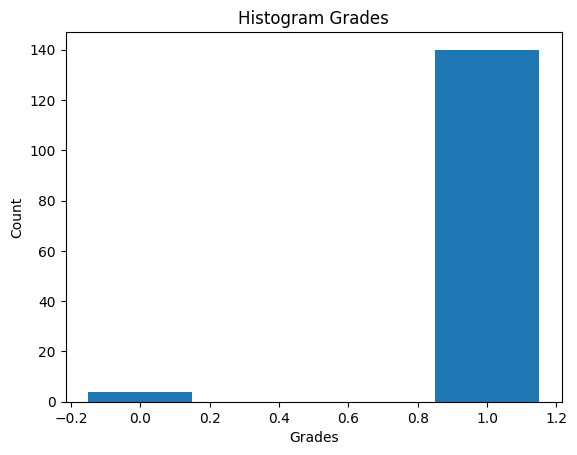

In [19]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade_normalized"], rwidth=.3, bins=np.arange(min(scores["grade_normalized"]), max(scores["grade_normalized"])+2) - 0.5)
plt.ylabel('Count')
plt.xlabel('Grades')
plt.show()


In [20]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

code  #user_prompts  #fix  #no  #can   
0  0031c86e-81f4-4eef-9e0e-28037abf9883           14.0   0.0  1.0   4.0  \
1  0225686d-b825-4cac-8691-3a3a5343df2b           18.0   0.0  0.0  10.0   
2  041f950b-c013-409a-a642-cffff60b9d4b            9.0   0.0  0.0  10.0   
3  04f91058-d0f8-4324-83b2-19c671f433dc           20.0   0.0  1.0   6.0   
4  089eb66d-4c3a-4f58-b98f-a3774a2efb34           86.0   2.0  5.0  30.0   

   #want  #entropy  #please  prompt_avg_chars  response_avg_chars  
0    1.0       0.0      7.0          2.205748          212.206370  
1    0.0       3.0      0.0          0.304163          113.633582  
2    0.0       3.0      1.0          0.262324           17.187601  
3    8.0       3.0      2.0          0.123346          107.092566  
4    4.0      26.0      0.0          0.017986           18.850913

In [21]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

code  #user_prompts  #fix  #no  #can   
0  0031c86e-81f4-4eef-9e0e-28037abf9883           14.0   0.0  1.0   4.0  \
1  0225686d-b825-4cac-8691-3a3a5343df2b           18.0   0.0  0.0  10.0   
2  041f950b-c013-409a-a642-cffff60b9d4b            9.0   0.0  0.0  10.0   
3  04f91058-d0f8-4324-83b2-19c671f433dc           20.0   0.0  1.0   6.0   
4  089eb66d-4c3a-4f58-b98f-a3774a2efb34           86.0   2.0  5.0  30.0   

   #want  #entropy  #please  prompt_avg_chars  response_avg_chars       Q_0   
0    1.0       0.0      7.0          2.205748          212.206370  0.275428  \
1    0.0       3.0      0.0          0.304163          113.633582  0.375875   
2    0.0       3.0      1.0          0.262324           17.187601  0.366049   
3    8.0       3.0      2.0          0.123346          107.092566  0.324133   
4    4.0      26.0      0.0          0.017986           18.850913  0.384348   

        Q_1       Q_2       Q_3       Q_4       Q_5       Q_6       Q_7   
0  0.541820  0.585343  0.578570  0.631297  0.652037  0.208264  0.294466  \
1  0.838402  0.790684  0.896132  0.676862  0.989898  0.886644  0.668303   
2  0.325979  0.680072  0.373324  0.728419  0.500546  0.594117  0.611976   
3  0.163248  0.317989  0.521366  0.419453  0.474453  0.230191  0.334378   
4  0.608783  0.798977  0.725802  0.790000  0.884630  0.738283  0.943205   

        Q_8  
0  0.232621  
1  0.836386  
2  0.345307  
3  0.705978  
4  0.826368

#### Merging scores with features

In [22]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

code  #user_prompts  #fix  #no  #can   
0  0031c86e-81f4-4eef-9e0e-28037abf9883           14.0   0.0  1.0   4.0  \
1  0225686d-b825-4cac-8691-3a3a5343df2b           18.0   0.0  0.0  10.0   
2  041f950b-c013-409a-a642-cffff60b9d4b            9.0   0.0  0.0  10.0   
3  04f91058-d0f8-4324-83b2-19c671f433dc           20.0   0.0  1.0   6.0   
4  089eb66d-4c3a-4f58-b98f-a3774a2efb34           86.0   2.0  5.0  30.0   

   #want  #entropy  #please  prompt_avg_chars  response_avg_chars  ...   
0    1.0       0.0      7.0          2.205748          212.206370  ...  \
1    0.0       3.0      0.0          0.304163          113.633582  ...   
2    0.0       3.0      1.0          0.262324           17.187601  ...   
3    8.0       3.0      2.0          0.123346          107.092566  ...   
4    4.0      26.0      0.0          0.017986           18.850913  ...   

        Q_1       Q_2       Q_3       Q_4       Q_5       Q_6       Q_7   
0  0.541820  0.585343  0.578570  0.631297  0.652037  0.208264  0.294466  \
1  0.838402  0.790684  0.896132  0.676862  0.989898  0.886644  0.668303   
2  0.325979  0.680072  0.373324  0.728419  0.500546  0.594117  0.611976   
3  0.163248  0.317989  0.521366  0.419453  0.474453  0.230191  0.334378   
4  0.608783  0.798977  0.725802  0.790000  0.884630  0.738283  0.943205   

        Q_8  grade  grade_normalized  
0  0.232621   48.0          0.388235  
1  0.836386   99.0          0.988235  
2  0.345307   90.0          0.882353  
3  0.705978   97.0          0.964706  
4  0.826368  100.0          1.000000  

[5 rows x 21 columns]

In [23]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 19) (122,)


#### Train/Test split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


#### Fitting a model

#### Predicting and Analyzing 

#### Decision Tree Regressesion

In [25]:
regressor = DecisionTreeRegressor(random_state= 42,criterion='squared_error', max_depth=5)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [26]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 163.42034222552866
Node 1 has MSE 216.8888888888887
Node 2 has MSE 0.0
Node 3 has MSE 64.0
Node 4 has MSE 0.0
Node 5 has MSE 0.0
Node 6 has MSE 45.800362154819595
Node 7 has MSE 26.246913580247565
Node 8 has MSE 10.639999999999418
Node 9 has MSE 2.66666666666697
Node 10 has MSE 0.0
Node 11 has MSE 1.0
Node 12 has MSE 1.0
Node 13 has MSE 0.0
Node 14 has MSE 0.0
Node 15 has MSE 6.977272727272975
Node 16 has MSE 1.3254437869809408
Node 17 has MSE 0.5306122448982933
Node 18 has MSE 0.25
Node 19 has MSE 0.46913580246928177
Node 20 has MSE 0.1875
Node 21 has MSE 0.0
Node 22 has MSE 6.770773000667759
Node 23 has MSE 1.9199999999982538
Node 24 has MSE 0.8402366863901989
Node 25 has MSE 0.22222222222080745
Node 26 has MSE 0.25
Node 27 has MSE 0.24305555555474712
Node 28 has MSE 0.0
Node 29 has MSE 0.0
Node 30 has MSE 0.9756235827680939
Node 31 has MSE 0.22222222222080745
Node 32 has MSE 0.0
Node 33 has MSE 0.0
Node 34 has MSE 0.24555555555525643
Node 35 has MSE 0.0
Node 36 has MS

In [27]:
# Plotting the Tree 
import graphviz

dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("hw")

'hw.pdf'

In [28]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 0.11475208640157092
MSE TEST: 11.900277777777779
R2 Train: 0.9992978102674439
R2 TEST: 0.8939988938928952


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


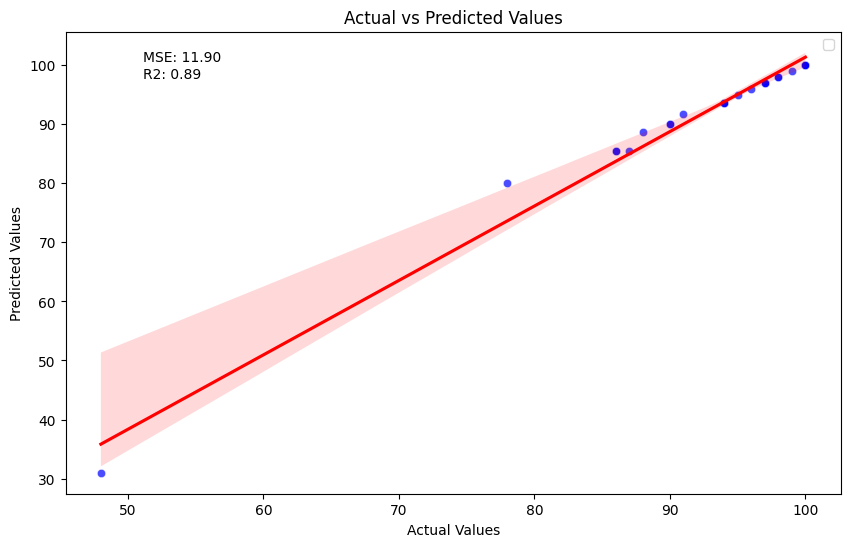

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Assuming y_test and y_test_pred are your actual and predicted values for the test set
plt.figure(figsize=(10, 6))

# Create a scatter plot
sns.scatterplot(x=y_test, y=y_test_pred, color='blue', alpha=0.7)

# Add a regression line
sns.regplot(x=y_test, y=y_test_pred, scatter=False, color='red', line_kws={'label':'Regression Line'})

# Add labels and title
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Calculate and display performance metrics
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)
plt.text(0.1, 0.9, f'MSE: {mse:.2f}\nR2: {r2:.2f}', transform=plt.gca().transAxes)

# Show legend
plt.legend()

# Show the plot
plt.show()


#### Neural Network


Epoch 1/10000
4/4 [==============================] - 1s 54ms/step - loss: 8598.8076 - mse: 8597.9355 - val_loss: 8550.5576 - val_mse: 8549.6865
Epoch 2/10000
4/4 [==============================] - 0s 14ms/step - loss: 8531.1875 - mse: 8530.3164 - val_loss: 8484.3623 - val_mse: 8483.4912
Epoch 3/10000
4/4 [==============================] - 0s 15ms/step - loss: 8430.5986 - mse: 8429.7266 - val_loss: 8421.1514 - val_mse: 8420.2783
Epoch 4/10000
4/4 [==============================] - 0s 12ms/step - loss: 8391.6826 - mse: 8390.8086 - val_loss: 8358.7539 - val_mse: 8357.8779
Epoch 5/10000
4/4 [==============================] - 0s 11ms/step - loss: 8323.7969 - mse: 8322.9199 - val_loss: 8294.2080 - val_mse: 8293.3281
Epoch 6/10000
4/4 [==============================] - 0s 11ms/step - loss: 8258.3877 - mse: 8257.5068 - val_loss: 8224.5029 - val_mse: 8223.6191
Epoch 7/10000
4/4 [==============================] - 0s 10ms/step - loss: 8165.1265 - mse: 8164.2412 - val_loss: 8147.4932 - val_mse: 81

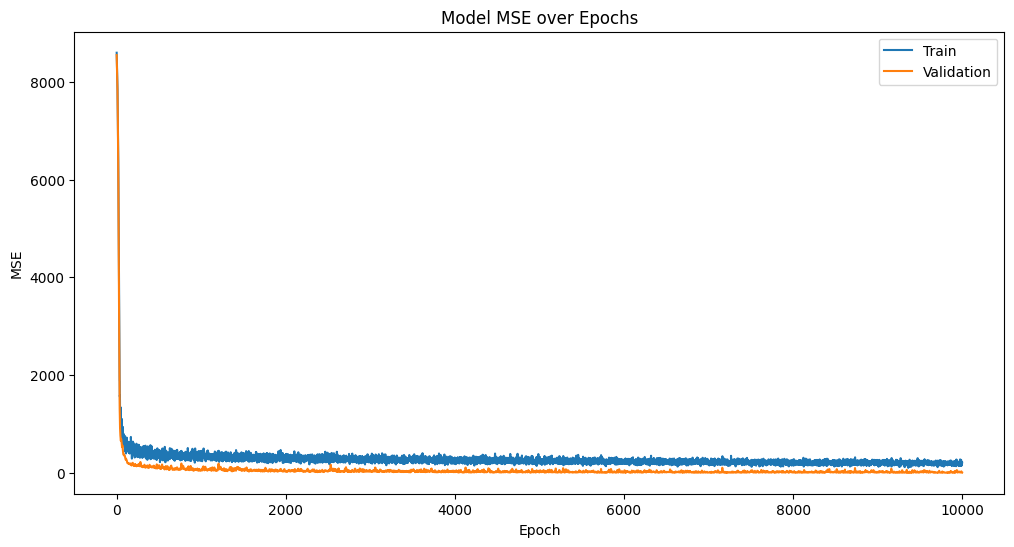

1/1 [==============================] - 0s 28ms/step
MSE Train: 4.274080033757048
MSE TEST: 3.828635608323384
R2 Train: 0.9738460954398285
R2 TEST: 0.9658966272097296


In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Normalize/Scale input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a more complex model architecture with dropout and regularization
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))  # Adding dropout for regularization
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.5))  # Adding another dropout layer
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Fit the model without early stopping and model checkpointing
history = model.fit(X_train_scaled, y_train, epochs=10000, batch_size=32, validation_data=(X_test_scaled, y_test))

# Plotting the training and validation MSE over epochs
plt.figure(figsize=(12, 6))

# Plot training & validation MSE values
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

plt.title('Model MSE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Prediction
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train, y_train_pred))
print("MSE TEST:", mean_squared_error(y_test, y_test_pred))

print("R2 Train:", r2_score(y_train, y_train_pred))
print("R2 TEST:", r2_score(y_test, y_test_pred))


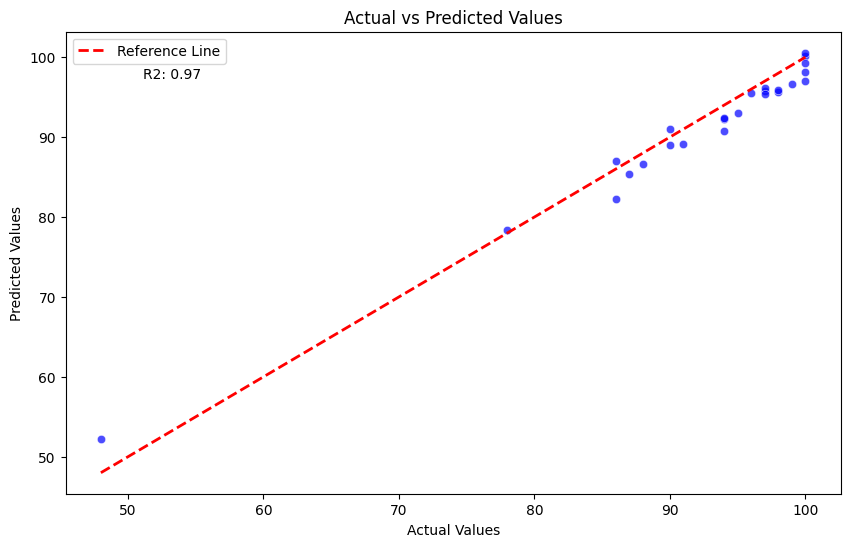

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Assuming y_test and y_test_pred are your actual and predicted values for the test set
plt.figure(figsize=(10, 6))

# Create a scatter plot
sns.scatterplot(x=y_test.flatten(), y=y_test_pred.flatten(), color='blue', alpha=0.7)

# Add a reference line (y = x)
plt.plot([min(y_test.flatten()), max(y_test.flatten())], [min(y_test.flatten()), max(y_test.flatten())], color='red', linestyle='--', linewidth=2, label='Reference Line')

# Add labels and title
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Calculate R2 score
r2 = r2_score(y_test, y_test_pred)
plt.text(0.1, 0.9, f'R2: {r2:.2f}', transform=plt.gca().transAxes)

# Show legend
plt.legend()

# Show the plot
plt.show()
